<a href="https://colab.research.google.com/github/hits-sdo/hits-sdo-similaritysearch/blob/byol-embeddings-analysis/search_byol/byol_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook to Intialize HITS-SDO self-similarity search environment
- Run all cells to initalize environment, and restart runtime if prompted to use updated versions. You will need to rerun the cells again to ensure that all dependencies have been installed.

# Download and Unzip Data

In [1]:
# Download Data
!gdown 15C5spf1la7L09kvWXll2qt67Ec0rwLsY

Downloading...
From: https://drive.google.com/uc?id=15C5spf1la7L09kvWXll2qt67Ec0rwLsY
To: /content/aia_171_color_1perMonth.tar.gz
100% 146M/146M [00:00<00:00, 167MB/s]


In [2]:
# Unzip file
!tar -zxf aia_171_color_1perMonth.tar.gz

In [3]:
# Print some files to see that they exist
!du aia_171_color_1perMonth/. -l -h

3.2M	aia_171_color_1perMonth/./20110722_000036_aia.lev1_euv_12s_4k/tiles
40K	aia_171_color_1perMonth/./20110722_000036_aia.lev1_euv_12s_4k/tile_meta_data
3.2M	aia_171_color_1perMonth/./20110722_000036_aia.lev1_euv_12s_4k
3.2M	aia_171_color_1perMonth/./20150530_000036_aia.lev1_euv_12s_4k/tiles
40K	aia_171_color_1perMonth/./20150530_000036_aia.lev1_euv_12s_4k/tile_meta_data
3.2M	aia_171_color_1perMonth/./20150530_000036_aia.lev1_euv_12s_4k
3.2M	aia_171_color_1perMonth/./20160210_000036_aia.lev1_euv_12s_4k/tiles
40K	aia_171_color_1perMonth/./20160210_000036_aia.lev1_euv_12s_4k/tile_meta_data
3.2M	aia_171_color_1perMonth/./20160210_000036_aia.lev1_euv_12s_4k
3.2M	aia_171_color_1perMonth/./20190202_000036_aia.lev1_euv_12s_4k/tiles
40K	aia_171_color_1perMonth/./20190202_000036_aia.lev1_euv_12s_4k/tile_meta_data
3.2M	aia_171_color_1perMonth/./20190202_000036_aia.lev1_euv_12s_4k
3.2M	aia_171_color_1perMonth/./20120505_000036_aia.lev1_euv_12s_4k/tiles
40K	aia_171_color_1perMonth/./20120505_0000

# Clone repository

In [4]:
# Clone the repository from GitHub
!git clone https://github.com/hits-sdo/hits-sdo-similaritysearch

fatal: destination path 'hits-sdo-similaritysearch' already exists and is not an empty directory.


In [5]:
%cd hits-sdo-similaritysearch/

/content/hits-sdo-similaritysearch


# Switch to Desired Branch

In [6]:
# Switch to the desired branch with requirements.txt
!git checkout byol-embeddings-analysis

Already on 'byol-embeddings-analysis'
Your branch is up to date with 'origin/byol-embeddings-analysis'.


In [7]:
# Confirm that branch is up to date
!git log --oneline

f90d9ae (HEAD -> byol-embeddings-analysis, origin/byol-embeddings-analysis) Merge branch 'byol-embeddings-analysis' of https://github.com/hits-sdo/hits-sdo-similaritysearch into byol-embeddings-analysis
6804358 Changed dataset augmentation options to none, single, and double
0627812 rename database to dataset to be consistent with pytorch conventions
02a851e Don't drop last batch, even if incomplete
a75f541 Update number of workers to take advantage of colab pro plus
372396e (origin/search-byol-experiment-2, search-byol-experiment-2) Added projection and prediction head output sizes to parameters
5f9ad14 Merge pull request #9 from hits-sdo/experimentation-1
71e1f41 Reduced the scheduler start to 0.1 saw huge increase of performance
91bb975 Higher learning rate experiment 1
a6c0a1b Add scheduler and hyperparameters to name
90fd5a9 Added more hyperparameters.
4f5b4cb Tags
9bc18d1 Expansion wandb init
d67150f Update branch checkout and "open in colab" button
3138a92 Merge pull request #8 

# Install all necesary packages into environment

In [8]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/hits-sdo/hits-sdo-packager.git (to revision pip_nodata) to /tmp/pip-req-build-vzbqnwju
  Running command git clone --filter=blob:none --quiet https://github.com/hits-sdo/hits-sdo-packager.git /tmp/pip-req-build-vzbqnwju
  Running command git checkout -b pip_nodata --track origin/pip_nodata
  Switched to a new branch 'pip_nodata'
  Branch 'pip_nodata' set up to track remote branch 'pip_nodata' from 'origin'.
  Resolved https://github.com/hits-sdo/hits-sdo-packager.git to commit 3a54caba2ae6bf7caf4eabaf580a6ffda1b3bbda
  Preparing metadata (setup.py) ... done


##  Load Modules

In [46]:
import copy
import numpy as np
from tqdm.autonotebook import tqdm

import torch
import torchvision
from torch import nn

import wandb
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors

from lightly.data import LightlyDataset
from lightly.data.multi_view_collate import MultiViewCollate
from lightly.loss import NegativeCosineSimilarity
from lightly.models.modules import BYOLPredictionHead, BYOLProjectionHead
from lightly.models.utils import deactivate_requires_grad, update_momentum
from lightly.transforms.simclr_transform import SimCLRTransform
from lightly.utils.scheduler import cosine_schedule

from search_byol.dataset import SDOTilesDataset

## Login to Wanddb and initialize logger

In [10]:
!wandb login --relogin

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## Define run parameters and initalize Wandb

In [79]:
seed = 42
from lightning.pytorch import seed_everything
seed_everything(seed, workers=True)

initial = "AMJ"
job_type = "AMJ"
epochs = 5
data_stride = 10
batch_size = 700
augmentation = 'double'
learning_rate = 0.1
cosine_scheduler_start = .1
cosine_scheduler_end = 1.0
projection_size = 2
prediction_size = 2

notes = "Commit message first experimentation run one"
name = f"{initial}-ds{data_stride}_bs{batch_size}_lr{learning_rate}_{augmentation}aug_ss{cosine_scheduler_start}_se{cosine_scheduler_end}_pjs{projection_size}_pds{prediction_size}"
group = "embedding-size"
tags = ["experimentation"]


wandb.init(
    # set the wandb project where this run will be logged
    project="search-byol-for_real",
    
    # track hyperparameters and run metadata
    config={
    "seed": seed,
    "batch size": batch_size,
    "augmention": augmentation,
    "data stride": data_stride,
    "learning_rate": learning_rate,
    "cosine_scheduler_start": cosine_scheduler_start,
    "cosine_scheduler_end": cosine_scheduler_end
    },
    entity = "search-byol",
    job_type = job_type,
    name = name,
    notes = notes,
    group = group,
    tags = tags,

)


INFO: Global seed set to 42
INFO:lightning.fabric.utilities.seed:Global seed set to 42


## Define BYOL Model

In [80]:
class BYOL(nn.Module):
    def __init__(self, backbone, projection_size=256, prediction_size=256):
        super().__init__()

        self.backbone = backbone
        self.projection_head = BYOLProjectionHead(512, 1024, projection_size)
        self.prediction_head = BYOLPredictionHead(projection_size, 1024, prediction_size)

        self.backbone_momentum = copy.deepcopy(self.backbone)
        self.projection_head_momentum = copy.deepcopy(self.projection_head)

        deactivate_requires_grad(self.backbone_momentum)
        deactivate_requires_grad(self.projection_head_momentum)

    def forward(self, x):
        y = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(y)
        p = self.prediction_head(z)
        return p

    def forward_momentum(self, x):
        y = self.backbone_momentum(x).flatten(start_dim=1)
        z = self.projection_head_momentum(y)
        z = z.detach()
        return z

## Initialize Module

In [81]:
resnet = torchvision.models.resnet18()
backbone = nn.Sequential(*list(resnet.children())[:-1])
model = BYOL(backbone, projection_size=projection_size, prediction_size=prediction_size)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

BYOL(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

## Initialize Dataloader

In [82]:
data_path = '/content/aia_171_color_1perMonth'
dataset = SDOTilesDataset(data_path=data_path, augmentation=augmentation, data_stride=data_stride)

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=False,
    num_workers=12,
)

## Run Training Loop 

In [83]:
criterion = NegativeCosineSimilarity()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


avg_loss = np.nan
print("Starting Training")
epoch = 0
epochs_bar = tqdm(range(epochs), dynamic_ncols=True, desc=f'Epoch {epoch:>02} - Av. loss: {avg_loss:.5f}')
for epoch in epochs_bar:
    total_loss = 0
    momentum_val = cosine_schedule(epoch, epochs, cosine_scheduler_start, cosine_scheduler_end)
    batches_bar = tqdm(dataloader, dynamic_ncols=True, leave=True, desc=f'Batches - Av. loss: {avg_loss:.5f}')
    for (x0, x1) in batches_bar:
        update_momentum(model.backbone, model.backbone_momentum, m=momentum_val)
        update_momentum(
            model.projection_head, model.projection_head_momentum, m=momentum_val
        )
        x0 = x0.to(device)
        x1 = x1.to(device)
        p0 = model(x0)
        z0 = model.forward_momentum(x0)
        p1 = model(x1)
        z1 = model.forward_momentum(x1)
        loss = 0.5 * (criterion(p0, z1) + criterion(p1, z0))
        total_loss += loss.detach()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        avg_loss = total_loss / len(dataloader)
        batches_bar.set_description(f'Epoch {epoch:>02} - Av. loss: {avg_loss:.5f} - Batches')
        batches_bar.refresh()        

    # log metrics to wandb
    wandb.log({"Av. loss": avg_loss})

    epochs_bar.set_description(f'Epoch {epoch:>02} - Av. loss: {avg_loss:.5f}')
    epochs_bar.refresh()

wandb.finish() 

Starting Training


Epoch 00 - Av. loss: nan:   0%|          | 0/5 [00:00<?, ?it/s]

Batches - Av. loss: nan:   0%|          | 0/16 [00:00<?, ?it/s]

Batches - Av. loss: -0.47105:   0%|          | 0/16 [00:00<?, ?it/s]

Batches - Av. loss: -0.78897:   0%|          | 0/16 [00:00<?, ?it/s]

Batches - Av. loss: -0.82614:   0%|          | 0/16 [00:00<?, ?it/s]

Batches - Av. loss: -0.87905:   0%|          | 0/16 [00:00<?, ?it/s]

Av. loss,█▃▂▁▁
Av. loss,-0.89736


## Running inference on dataset without augmentation

In [84]:
dataset_inference = SDOTilesDataset(data_path=data_path, augmentation='none', data_stride=10)

dataloader_inference = torch.utils.data.DataLoader(
    dataset,
    batch_size=len(dataset_inference),
    shuffle=True,
    drop_last=False,
    num_workers=12,
)

In [85]:
data = next(iter(dataloader_inference))[0]
data.shape

torch.Size([10506, 3, 128, 128])

In [86]:
embeddings_inference = model.forward_momentum(data.cuda()).cpu().numpy()
embeddings_inference.shape

(10506, 2)

## Plotting Embeddings

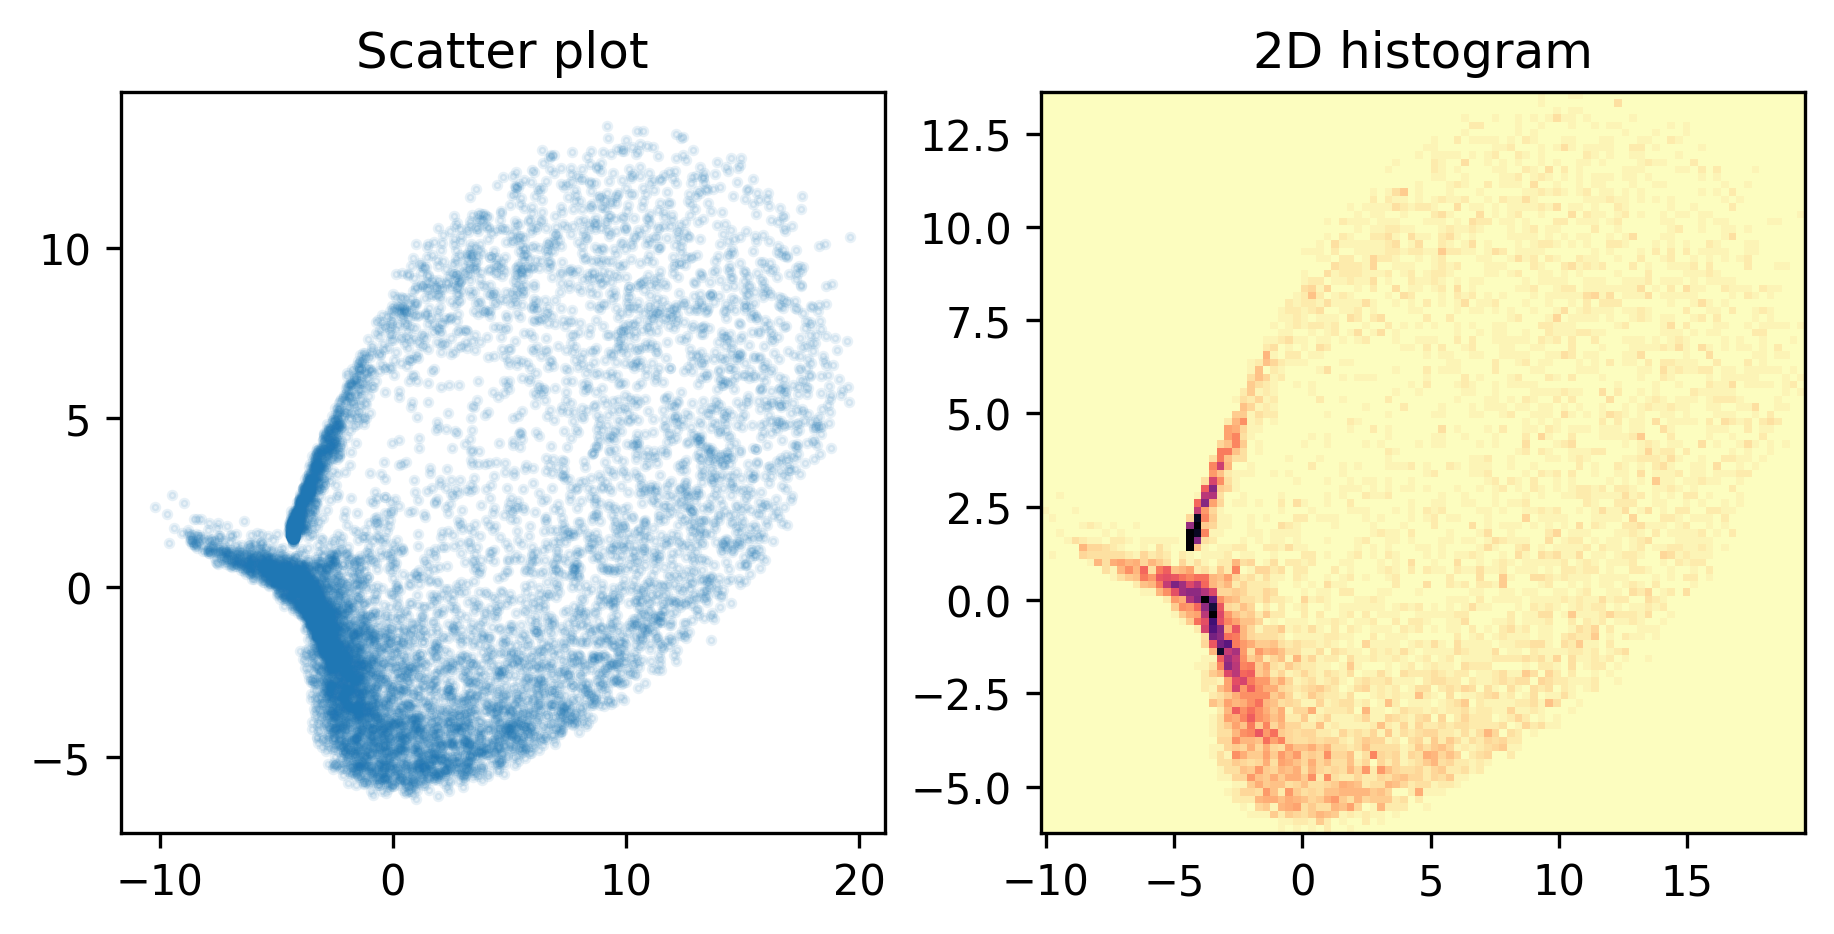

In [97]:
fig = plt.figure(figsize=[6,3], layout='constrained', dpi=300)
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

# Scatter plot
ax1 = fig.add_subplot(spec[0, 0])
ax1.scatter(embeddings_inference[:,0], embeddings_inference[:,1], s=3, alpha=0.1)
ax1.set_title('Scatter plot')

# 2D histogram
ax2 = fig.add_subplot(spec[0, 1])
histout = np.histogram2d(embeddings_inference[:,0], embeddings_inference[:,1], bins=50)
ax2.hist2d(embeddings_inference[:,0], embeddings_inference[:,1], bins=100, cmap=plt.cm.magma_r, vmax=np.percentile(histout[0], 99))
ax2.set_title('2D histogram');